In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Combine data frames

In [3]:
def sanity_check(df):
    print df.shape
    print 'num formulas'
    print df.shape[0] / 21

In [4]:
dfa = pd.read_csv('joined15.csv')
dfb = pd.read_csv('joined1617.csv')
sanity_check(dfa)
sanity_check(dfb)

(861, 15)
num formulas
41
(441, 15)
num formulas
21


In [5]:
df = dfa.append(dfb)
sanity_check(df)

(1302, 15)
num formulas
62


need to add sanity check for duplicate formulas (in 15,16,17)

## Load data frame

In [6]:
df.head()

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time
0,exp2,COMiniSatPS-6,40bits_10.dimacs.cnf,446,12980,61.07870,224458,255797,475.0,16165613,0.130045,0.869955,2.0,0.0,4.79127
1,exp2,COMiniSatPS-5,40bits_10.dimacs.cnf,446,12980,36.70640,234944,274595,367.0,14949163,0.130045,0.869955,2.0,0.0,4.79127
2,exp5,wrapper-60,40bits_10.dimacs.cnf,446,12980,15.73160,117363,154663,356.0,4992154,0.130045,0.869955,2.0,0.0,4.79127
3,exp4,wrapper-glucose,40bits_10.dimacs.cnf,446,12980,2.13967,26069,32948,64.0,979665,0.130045,0.869955,2.0,0.0,4.79127
4,exp2,COMiniSatPS-4,40bits_10.dimacs.cnf,446,12980,48.07070,222780,258214,319.0,15949794,0.130045,0.869955,2.0,0.0,4.79127


In [7]:
# find timeout formulas
terminated_formulas = set()
for index, row in df[df['variables'] == 0].iterrows():
    terminated_formulas.add(row['formula'])

terminated_formulas

{'aes_32_3_keyfind_1.cnf', 'aes_32_3_keyfind_2.cnf'}

In [8]:
for f in terminated_formulas:
    df = df.drop(df[df['formula'] == f].index)

In [9]:
df = df.reset_index()

TODO:results file isnt good (should filter terminated/unsat formulas in the python script instead of here).

## Add solution density

In [10]:
df['solution_density'] = df.apply(lambda x: (math.log(x['num_sols'], 2) / x['variables']), axis=1)

## Extract formulas list

In [11]:
formulas_set = set()
for index, row in df.iterrows():
    formulas_set.add(row['formula'])

print(len(formulas_set))

59


# Helpers for experiments

In [12]:
def create_secondary_dataframe(df, exp, formulas_set, a_val, b_val):
    """
        Creates a secondary data frame for checking runtime diffs
        columns = ['formula', 'entropy', 'solution_density', 'backbone', 'diff']
        a_val and b_val are the actual solvers
        diff is a_runtime - b_runtime
    """
    # get experiment
    exp_df = df[df['experiment'] == exp]
    # create df
    columns = ['formula', 'entropy', 'solution_density', 'backbone', 'diff']
    out_df = pd.DataFrame(columns=columns)

    for index, f in enumerate(formulas_set):
        # get formula,solver row
        df_a = exp_df[(df['formula'] == f) & (df['solver'] == a_val)]
        df_b = exp_df[(df['formula'] == f) & (df['solver'] == b_val)]
        # should have 1 rows after manipulation
        assert(df_a.shape[0] == 1)
        assert(df_b.shape[0] == 1)

        out_df.loc[index] = [f, 
                              df_a.iloc[0]['entropy'], 
                              #math.log(df_a.iloc[0]['num_sols'], 2) / df_a.iloc[0]['variables'],
                              df_a.iloc[0]['solution_density'],
                              df_a.iloc[0]['backbone'], 
                              df_a.iloc[0]['runtime'] - df_b.iloc[0]['runtime']
                             ]
    return out_df

In [13]:
def plotter(df, exp, formulas_set, a_val, b_val, x_property, x_lim=None, y_lim=None):
    """
        Plot diff (a_val - b_val) with x as x_property (could be entropy, num_sols, backbone)
    """
    exp_df = create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    x = exp_df[x_property]
    y = exp_df['diff']
    # regression line
    m, b = np.polyfit(x, y, 1)
    plt.plot(x , y, 'ro')
    plt.plot(x, m*x + b, '-')
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    plt.xlabel(str(x_property))
    plt.ylabel('Runtime (seconds)')
    title = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    plt.title(title)
    plt.show()

In [14]:
def entropy_sols_plotter(df, exp, formulas_set, a_val, b_val):
    plotter(df, exp, formulas_set, a_val, b_val, 'entropy', x_lim=(0,df['entropy'].max()))
    plotter(df, exp, formulas_set, a_val, b_val, 'solution_density', x_lim=(0,df['solution_density'].max()))

# Exp1 - Database reduction: (With - Without)

## Plots

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


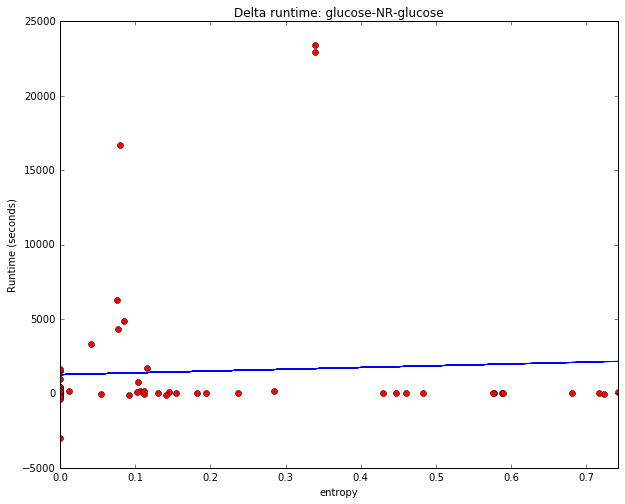

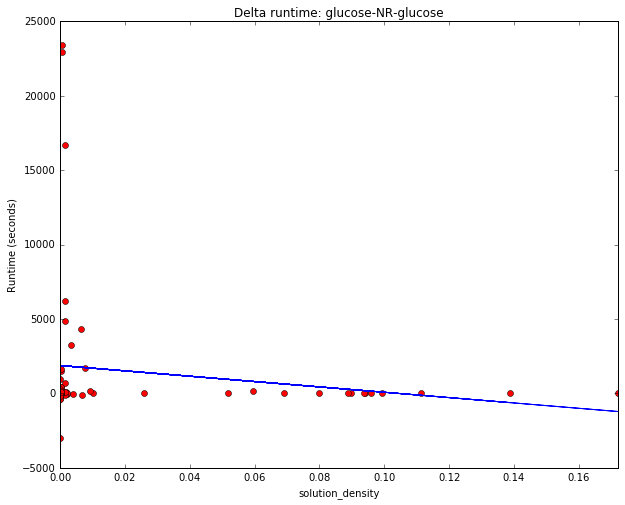

In [15]:
entropy_sols_plotter(df, 'exp1', formulas_set, 'glucose-NR', 'glucose')

There's high variation with low entropy (and low density), and it stabilizes as entropy increases.

# Exp2: Controlling lbd-cut (LBD1 - LBD5)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


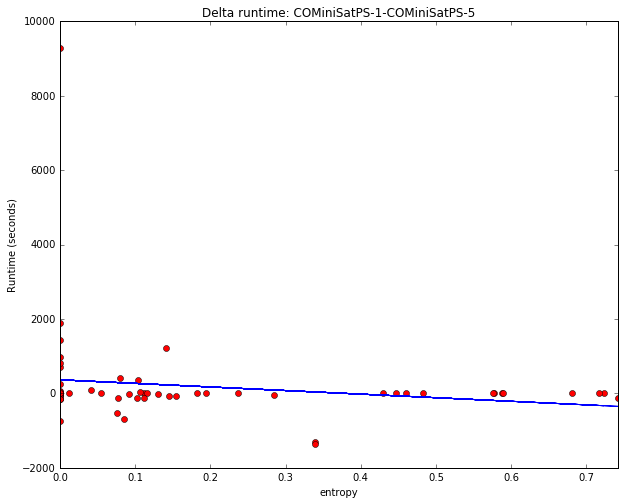

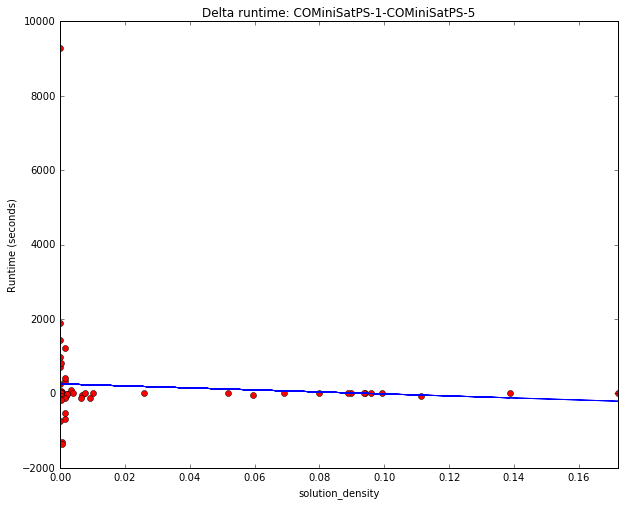

In [16]:
entropy_sols_plotter(df, 'exp2', formulas_set, 'COMiniSatPS-1', 'COMiniSatPS-5')

Entropy trend same as our paper, about solution density we can tell there's high variation in low density formulas.

## LBD0 - LBD5

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


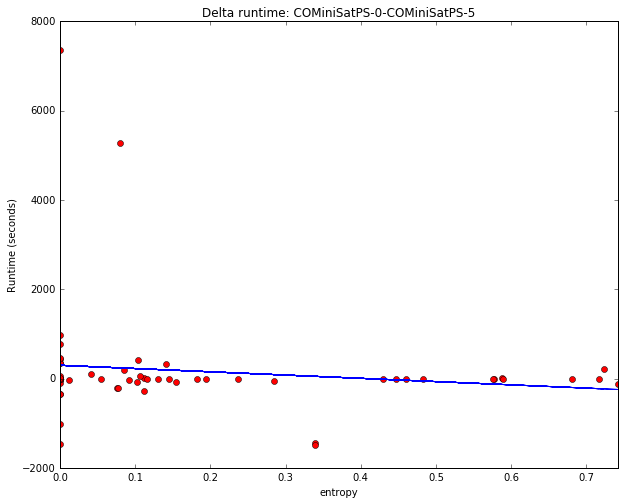

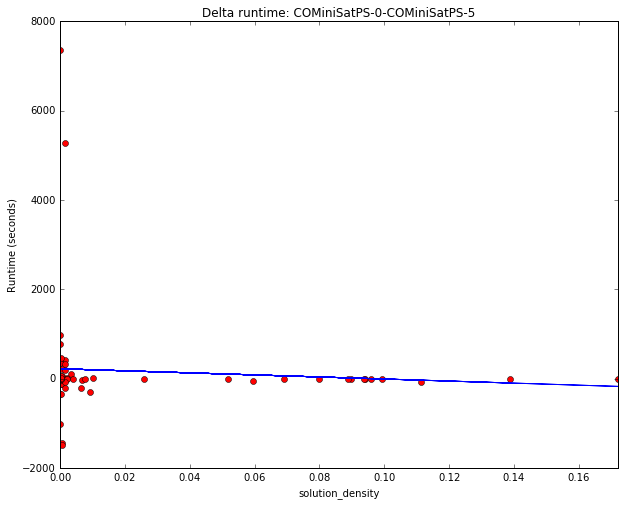

In [17]:
entropy_sols_plotter(df, 'exp2', formulas_set, 'COMiniSatPS-0', 'COMiniSatPS-5')

Same as before (but density trend is different)

# Exp3 - Saving criterion - Clause-size - Lbd

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


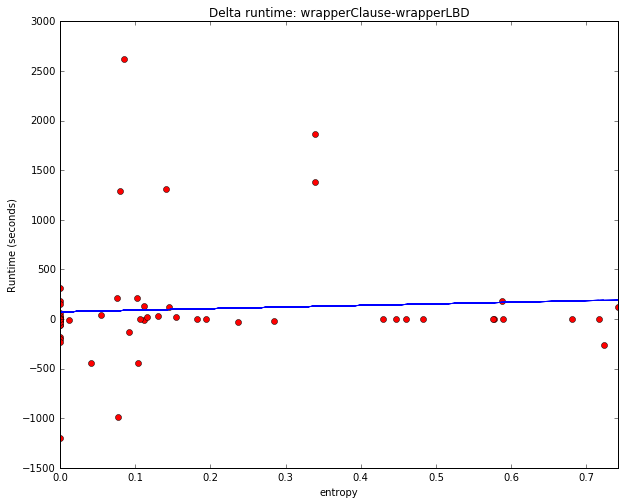

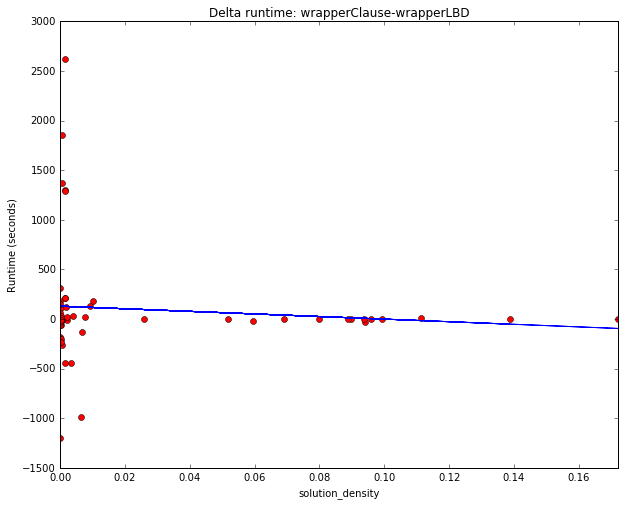

In [18]:
entropy_sols_plotter(df, 'exp3', formulas_set, 'wrapperClause', 'wrapperLBD')

The variation is more significant with low entropy and low density. Trends aren't like our paper (but maybe it's early to decide)

# Exp4 - Restarts type (Luby - Glucose)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


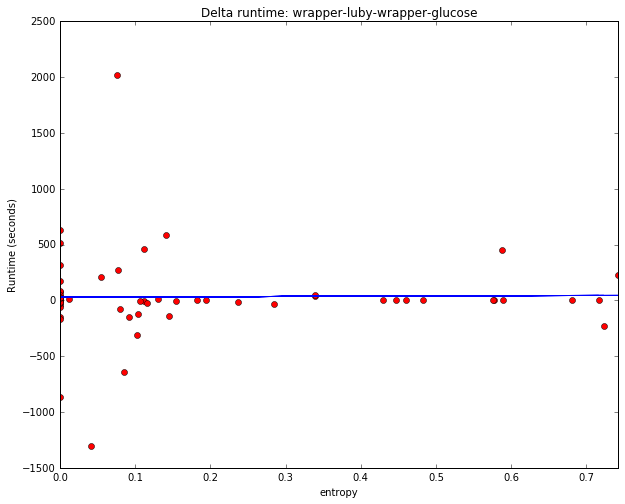

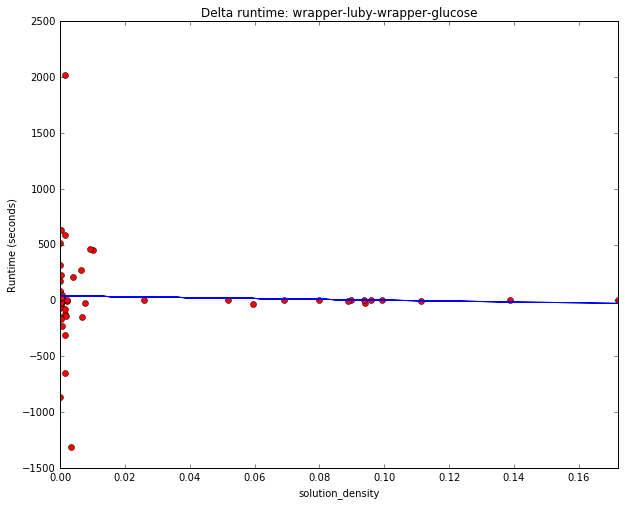

In [19]:
entropy_sols_plotter(df, 'exp4', formulas_set, 'wrapper-luby', 'wrapper-glucose')

Same trend as our paper

# Exp5 - Variable decay factor (G0.6 - G0.95)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


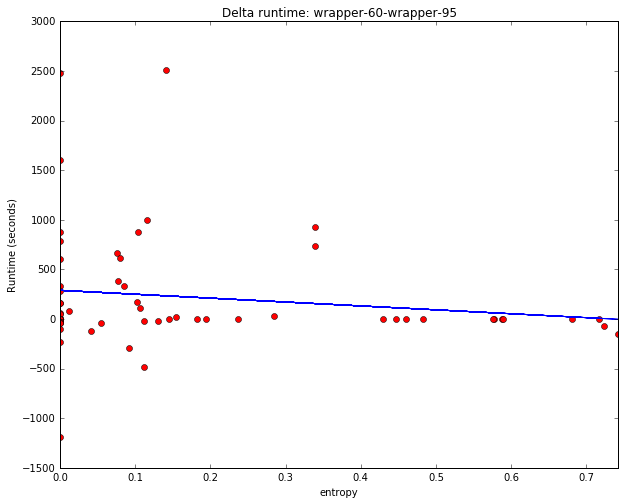

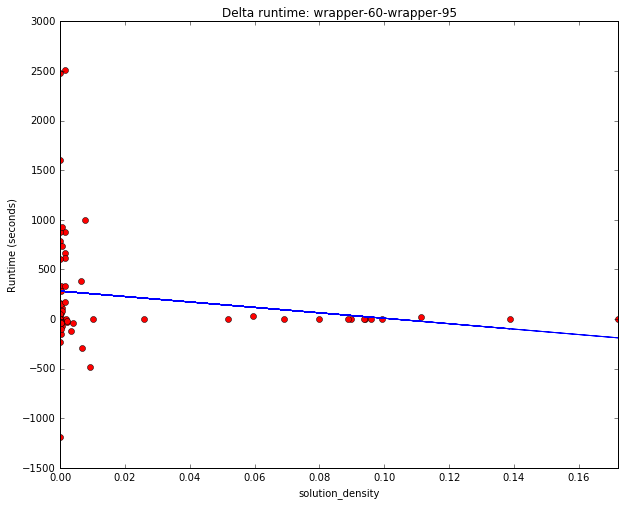

In [20]:
entropy_sols_plotter(df, 'exp5', formulas_set, 'wrapper-60', 'wrapper-95')

For low entropy there's high variation, for high entropy the diff is low.

About density - same as our paper

# Summary

The trends aren't 100% same as our paper (but not that different), although we have more formulas to add (2016-2017) to our dataset

I think we should emphasize the large variation between the engines for low entropy, and small variation for high entropy. 

Why should we care about it? The entropy/solution density could be a new measure for the hardness of SATISFIABLE formulas. If for example we work in the industry on some kind of formula, we could run the entropy (solution density) approximator once to tell us if the formula has high or low entropy (solution density). Another scenario: tell something about the competitions formulas (do they have small entropy on average?).

TODO:
* We should filter formulas with runtime < 15 seconds (?)



## How large is the variation between all engines (for entropy/density < threshold)?

Global variation (all entropies)

In [21]:
print(df['entropy'].mean(), df['entropy'].std())

(0.17506069491525403, 0.22779900448338386)


Low entropy

In [22]:
def threshold_mean_std(df, threshold, prop):
    print 'low %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] < threshold][prop].mean(),
                                 df[df[prop] < threshold][prop].std())
    print 'high %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] >= threshold][prop].mean(),
                                 df[df[prop] >= threshold][prop].std())

In [23]:
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'entropy')
    print

threshold: 0.100000
low entropy
mean 0.016770, std 0.030996
high entropy
mean 0.350311, std 0.223218

threshold: 0.200000
low entropy
mean 0.049181, std 0.060438
high entropy
mean 0.513362, std 0.156310

threshold: 0.300000
low entropy
mean 0.058566, std 0.073560
high entropy
mean 0.549507, std 0.131781

threshold: 0.400000
low entropy
mean 0.070531, std 0.091677
high entropy
mean 0.584470, std 0.108080

threshold: 0.500000
low entropy
mean 0.100689, std 0.135913
high entropy
mean 0.649179, std 0.068735

threshold: 0.600000
low entropy
mean 0.135737, std 0.181123
high entropy
mean 0.715763, std 0.022215

threshold: 0.700000
low entropy
mean 0.145477, std 0.193499
high entropy
mean 0.727282, std 0.011013

threshold: 0.800000
low entropy
mean 0.175061, std 0.227799
high entropy
mean nan, std nan



Notice how the standard deviation is increasing for low entropy and decreasing for high entropy, as we increase the threshold.

In [24]:
for thres in [0.01, 0.05, 0.1, 0.15, 0.2]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'solution_density')
    print

threshold: 0.010000
low solution_density
mean 0.001333, std 0.002187
high solution_density
mean 0.085339, std 0.039068

threshold: 0.050000
low solution_density
mean 0.002056, std 0.004337
high solution_density
mean 0.095703, std 0.030718

threshold: 0.100000
low solution_density
mean 0.016369, std 0.031666
high solution_density
mean 0.140699, std 0.025057

threshold: 0.150000
low solution_density
mean 0.020115, std 0.036984
high solution_density
mean 0.172089, std 0.000000

threshold: 0.200000
low solution_density
mean 0.022691, std 0.041590
high solution_density
mean nan, std nan



Same goes for solution density, although we don't have much diversity in its values.